In [1]:
import sys
sys.path.append('../../')
from experiments.risk_scores_data import generate_data, get_nodes_feature, get_age_feature, get_bmi_feature
from experiments.utils import create_df_from_cached_results, load_share_from_checkpoint
from sklearn.metrics import r2_score
from gplearn.gplearn.genetic import SymbolicRegressor
from gplearn.gplearn.model import ShapeNN
import matplotlib.pyplot as plt
import time
import torch
import pandas as pd
import numpy as np

In [2]:
# Read the timestamp from the file
with open('../results/Figure_4_timestamp.txt','r') as f:
    timestamp = f.read()
# Read dataframe
res_df = pd.read_csv(f'../results/Figure_4_results.csv', index_col=0)

In [3]:
res_df

,id,equation,raw_fitness,r2,r2_val,r2_train,n_shapes,n_variables
0,0,"add(X0, X1)",7380.957000,-13860.535182,-12194.578675,-12972.325723,0,2
1,1,"add(X0, shape(X2))",230.545044,-431.966654,-353.711970,-388.147904,1,2
2,2,"div(div(shape(X1), shape(X0)), shape(X2))",0.494983,0.070415,0.189743,0.133656,3,3
3,3,"shape(add(add(X0, shape(X1)), shape(X2)))",0.125024,0.765204,0.778889,0.851743,3,3
4,4,"div(shape(mul(shape(X1), shape(X2))), shape(X0))",0.093954,0.823552,0.804884,0.844692,4,3
...,...,...,...,...,...,...,...,...
414,414,"div(X1, mul(shape(X2), shape(X0)))",388.863190,-729.290221,-668.999508,-656.759397,2,3
415,415,"add(X2, shape(add(X1, X0)))",74.481209,-138.876682,-141.589148,-123.217457,1,3
416,416,"add(shape(div(X0, shape(X1))), shape(X2))",0.137409,0.741944,0.664848,0.830918,3,3
417,417,"add(mul(X0, shape(X1)), X2)",375.457855,-704.114879,-537.588892,-523.983110,1,3


In [4]:
res_df[res_df['n_shapes'] == 0].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                              376
equation       div(X0, mul(X2, X1))
raw_fitness                0.835831
r2                        -0.569701
r2_val                    -0.267081
r2_train                  -0.498106
n_shapes                          0
n_variables                       3
Name: 376, dtype: object

In [5]:
res_df[res_df['n_shapes'] == 1].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                            242
equation       mul(X1, shape(X2))
raw_fitness              0.189925
r2                       0.643317
r2_val                    0.63029
r2_train                 0.679479
n_shapes                        1
n_variables                     2
Name: 242, dtype: object

In [6]:
res_df[res_df['n_shapes'] == 2].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                   301
equation       add(shape(X1), shape(X2))
raw_fitness                     0.118383
r2                              0.777676
r2_val                          0.846697
r2_train                        0.870079
n_shapes                               2
n_variables                            2
Name: 301, dtype: object

In [7]:
res_df[res_df['n_shapes'] == 3].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                                   418
equation       add(add(shape(X0), shape(X1)), shape(X2))
raw_fitness                                     0.000584
r2                                              0.998904
r2_val                                          0.998844
r2_train                                        0.999131
n_shapes                                               3
n_variables                                            3
Name: 418, dtype: object

In [8]:
res_df[res_df['n_shapes'] == 4].sort_values(by='r2_train',ascending=False).iloc[0,:]

id                                                          303
equation       shape(add(add(shape(X2), shape(X0)), shape(X1)))
raw_fitness                                            0.003376
r2                                                      0.99366
r2_val                                                 0.988938
r2_train                                               0.995273
n_shapes                                                      4
n_variables                                                   3
Name: 303, dtype: object

In [11]:
def evaluate_shape(shape,t):
    shape.to(torch.device('cpu'))
    t = torch.from_numpy(t).float()
    shape.eval()
    with torch.no_grad():
        return shape(t).numpy().flatten()

In [12]:
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
linewidth = 2.0
alpha = 0.5
markersize = 5.0
label_fontsize = 15

In [13]:
def plot_1(ax,s):
    t = np.linspace(0,50,1000)
    node = get_nodes_feature()
    ax.plot(t,node(t),'-', c=colors[0], markersize=markersize,linewidth=linewidth, alpha=alpha, label="Ground truth")
    ax.plot(t,evaluate_shape(s,t),c=colors[1],linewidth=linewidth, alpha=alpha, label=r"$s_1(x_{nodes})+s_2(x_{age})+s_3(x_{bmi})$")
    ax.set_xlabel(r'$x_{nodes}$', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_1$", fontsize=label_fontsize)


In [14]:
def plot_2(ax,s):
    t = np.linspace(45,70,1000)
    node = get_age_feature()
    ax.plot(t,node(t),'-', c=colors[0], markersize=markersize,linewidth=linewidth, alpha=alpha, label="Ground truth")
    ax.plot(t,evaluate_shape(s,t),c=colors[1],linewidth=linewidth, alpha=alpha, label=r"$s_1(x_{nodes})+s_2(x_{age})+s_3(x_{bmi})$")
    ax.set_xlabel(r'$x_{age}$', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_2$", fontsize=label_fontsize)


In [15]:
def plot_3(ax,s):
    t = np.linspace(17,45,1000)
    node = get_bmi_feature()
    ax.plot(t,node(t),'-', c=colors[0], markersize=markersize,linewidth=linewidth, alpha=alpha, label="Ground truth")
    ax.plot(t,evaluate_shape(s,t),c=colors[1],linewidth=linewidth, alpha=alpha, label=r"SHARE")
    ax.set_xlabel(r'$x_{bmi}$', fontsize=label_fontsize)
    ax.set_ylabel(r"$s_3$", fontsize=label_fontsize)


add(add(shape(X0), shape(X1)), shape(X2))


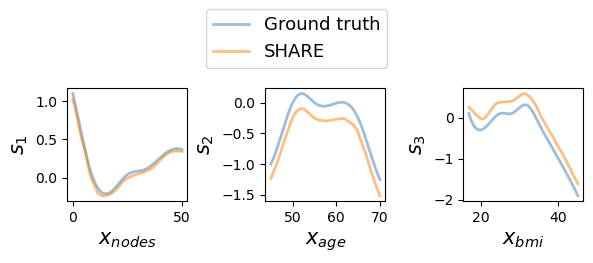

In [16]:
sorted_filtered = res_df[res_df['n_shapes'] == 3].sort_values(by='r2_train',ascending=False)
eq = sorted_filtered.iloc[0,1]
id = sorted_filtered.iloc[0,0]
esr_best = load_share_from_checkpoint(timestamp, eq, checkpoint_dir='../results/checkpoints', task='regression',n_features=3, equation_id=id)
s1 = esr_best._program.model.shape_functions[0]
s2 = esr_best._program.model.shape_functions[1]
s3 = esr_best._program.model.shape_functions[2]

fig, axs = plt.subplots(1,3, figsize=(6,2.5))
plot_1(axs[0],s1)
plot_2(axs[1],s2)
plot_3(axs[2],s3)
handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=13)
plt.subplots_adjust(left=0.12, bottom=0.20, right=0.98, top=0.65, wspace=0.65, hspace=None)
plt.savefig('figures/Figure_4.pdf')